In [10]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
warnings.filterwarnings("ignore")
from numpy import inf

In [11]:
# read all of the data
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [49]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w          = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg  = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return [self.layer,self.layerA]

    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)
        
        return [grad,grad_pass]
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
    
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
  
class tf_box_cox():
    
    def __init__(self):
        self.lmbda = tf.Variable(2.0)
    
    def feedforward(self,data):
        self.input = data
        self.layer = (tf.pow((self.input + 1.0),self.lmbda) - 1.0)/self.lmbda
        return self.layer 
    
    def backprop(self,grad):
        grad_input = tf.pow((self.input + 1),self.lmbda-1.0)
        
        # Grad respect to the lmbda value (not tested!)
        grad_lmbda = tf.pow((self.input+1),self.lmbda) * \
        (tf.log(self.input+1)*self.lmbda -1) + 1
        grad_lmbda = grad_lmbda / (self.lmbda ** 2)
        
        return grad_input * grad

class tf_min_max_layer():
    
    def __init__(self,vector_shape,user_max=1.0,user_min=0.0):
        self.moving_min = tf.Variable(tf.zeros(shape=(vector_shape,1),dtype=tf.float32))
        self.moving_max = tf.Variable(tf.zeros(shape=(vector_shape,1),dtype=tf.float32))
        self.user_min   = tf.Variable(user_min,dtype=tf.float32); 
        self.user_max   = tf.Variable(user_max,dtype=tf.float32); 
        
    def feedforward(self,input,training_phase):
        self.input    = input
        self.min_vec  = tf.reduce_min(input,-1)[:,None]
        self.min_index= tf.argmin(input,-1)
        self.max_vec  = tf.reduce_max(input,-1)[:,None]
        self.max_index= tf.argmax(input,-1)
        
        def training_fn():
            normalized_data = (self.user_max-self.user_min)  * \
            ((self.input - self.min_vec)/(self.max_vec - self.min_vec))          + self.user_min
            
            update_min_max = []
            update_min_max.append(tf.assign(self.moving_min,self.moving_min * 0.9 + 0.1 * self.min_vec))
            update_min_max.append(tf.assign(self.moving_max,self.moving_max * 0.9 + 0.1 * self.max_vec))
            return normalized_data,update_min_max
        
        # Testing Moving Average Mean        
        def  testing_fn():
            normalized_data = (self.user_max-self.user_min) * \
            ((self.input - self.moving_min)/(self.moving_max - self.moving_min)) + self.user_min
            
            update_min_max = []
            update_min_max.append(tf.assign(self.moving_min,self.moving_min))
            update_min_max.append(tf.assign(self.moving_max,self.moving_max))
            return normalized_data,update_min_max
        
        self.output,update_min_max = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_min_max
    
    def backprop(self,grad):
        grad1   = grad
        
        # Create Mask for min / max value for row
        indices = tf.range(0, self.input.shape[0].value,dtype=tf.int64)
        min_indices = tf.stack([indices, self.min_index], axis=1)
        max_indices = tf.stack([indices, self.max_index], axis=1)
        grad_min = tf.cast(tf.sparse_to_dense(min_indices, self.input.shape, sparse_values=1, default_value=0),dtype=tf.float32)
        grad_max = tf.cast(tf.sparse_to_dense(max_indices, self.input.shape, sparse_values=1, default_value=0),dtype=tf.float32)
        
        grad_max_min = 1.0/(self.max_vec-self.min_vec)
        grad_pass    = grad1 * (self.user_max-self.user_min) * (
            grad_max_min + \
            (self.input - self.max_vec)/tf.square(grad_max_min) * grad_min + \
            (self.min_vec - self.input)/tf.square(grad_max_min) * grad_max
        )
        
        return grad_pass

class tf_svd_layer():
    
    def __init__(self,batch_size,size,width):
        self.n = size
        self.moving_s = tf.Variable(tf.zeros((batch_size,size),dtype=tf.float32))
        self.moving_u = tf.Variable(tf.zeros((batch_size,width**2,size),dtype=tf.float32))
        self.moving_v = tf.Variable(tf.zeros((batch_size,size,size),dtype=tf.float32))
    
    def feedforward(self,data,training_phase):
        
        with tf.device('/cpu:0'):
            s,U,V = tf.svd(data)
        smin = tf.reduce_min(s,1,keepdims=True)
        smax = tf.reduce_max(s,1,keepdims=True)
        scaleds = (s - smin)/(smax-smin + 1e-8)
        def training_fn():
            data      = U[:,:,:] @ tf.matrix_diag(s)[:,:,:] @ tf.transpose(V,(0,2,1))[:,:,:]
            data = data  * tf.reduce_mean(tf.transpose(tf.abs(V),(0,2,1)) * scaleds[:,:,None] ,(1),keepdims=True)
            # data      = data * tf.reduce_mean(tf.transpose(tf.abs(V),(0,2,1)) * scaleds[:,:,None] ,(1),keepdims=True)
            update = []
            update.append(tf.assign(self.moving_u,self.moving_u*0.9 + 0.1 * U))
            update.append(tf.assign(self.moving_v,self.moving_v*0.9 + 0.1 * V))
            return data,update
            
        def testing_fn():
            data      = U[:,:,:] @ tf.matrix_diag(s)[:,:,:] @ tf.transpose(V,(0,2,1))[:,:,:]
            # data      = data * tf.reduce_mean(tf.transpose(tf.abs(V),(0,2,1)) * scaleds[:,:,None] ,(1),keepdims=True)
            update = []
            update.append(tf.assign(self.moving_u,self.moving_u))
            update.append(tf.assign(self.moving_v,self.moving_v))
            return data,update
        
        data,update  = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return data,update
    
class tf_svd_layer_std():
    
    def __init__(self,batch_size,channel_size):
        self.moving_s = tf.Variable(tf.zeros((batch_size,channel_size),dtype=tf.float32))
    
    def feedforward(self,data,training_phase):
        
        with tf.device('/cpu:0'):
            s,U,V = tf.svd(data)

        smean,sstd = tf.nn.moments(s, axes=(-1))

        def training_fn():
            snorm  = (s-smean[:,None])/sstd[:,None] + smean[:,None]
            data   = U @ tf.matrix_diag(snorm) @ tf.transpose(V,(0,2,1))
            update = []
            update.append(tf.assign(self.moving_s,self.moving_s*0.9 + 0.1 * snorm))
            return data,update
            
        def testing_fn():
            data   = U @ tf.matrix_diag(self.moving_s) @ tf.transpose(V,(0,2,1))
            update = []
            update.append(tf.assign(self.moving_s,self.moving_s))
            return data,update
        
        data,update  = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return data,update
    
    def backprop(self,grad):
        raise NotImplemented('Do not rely on Auto Differentiation')
    
def show_histogram(layer1,layer1a,grad1w,grad1p):
    plt.figure(figsize=(20,5))
    plt.subplot(141); plt.hist(layer1. ravel(),batch_size); plt.title('layer')
    plt.subplot(142); plt.hist(layer1a.ravel(),batch_size); plt.title('layer a')
    plt.subplot(143); plt.hist(grad1w.ravel(),batch_size); plt.title('grad w')
    plt.subplot(144); plt.hist(grad1p.ravel(),batch_size); plt.title('grad p')
    plt.show()   

In [13]:
# hyper paraneter for all 
num_epoch = 50; batch_size = 20 ; learning_rate = 0.0008; 

In [19]:
# frist batch normalization
# sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_batch_norm_layer(16,(0,1,2))
l2 = CNN(3,16,16); l2n = tf_batch_norm_layer(16,(0,1,2))
l3 = CNN(3,16,16); l3n = tf_batch_norm_layer(16,(0,1,2))
l4 = CNN(3,16,16); l4n = tf_batch_norm_layer(16,(0,1,2))
l5 = CNN(3,16,16); l5n = tf_batch_norm_layer(16,(0,1,2))
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)

layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

update_ops  = update1 + update2 + update3 + update4 + update5
final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('figure/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.35
 Current : 0 Acc : 0.2598000031709671 Test Acc : 0.31537500210106373

Current Iter : 1/50 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.32500000163912773 Test Acc : 0.3465000016335398

Current Iter : 2/50 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.35980000177025795 Test Acc : 0.36875000143423675

Current Iter : 3/50 batch : 7980/8000 acc : 0.55
 Current : 3 Acc : 0.39720000022649765 Test Acc : 0.3572500013373792

Current Iter : 4/50 batch : 7980/8000 acc : 0.55
 Current : 4 Acc : 0.42340000092983243 Test Acc : 0.38600000108592214

Current Iter : 5/50 batch : 7980/8000 acc : 0.45
 Current : 5 Acc : 0.45360000151395796 Test Acc : 0.43537500105798244

Current Iter : 6/50 batch : 7980/8000 acc : 0.45
 Current : 6 Acc : 0.4786000017821789 Test Acc : 0.42825000051409007

Current Iter : 7/50 batch : 7980/8000 acc : 0.55
 Current : 7 Acc : 0.5080000010132789 Test Acc : 0.4410000009275973

Current Iter : 8/50 batch : 7980/8000 acc : 0.

In [25]:
# frist layer normalization

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_layer_norm_layer(batch_size,(1,2,3))
l2 = CNN(3,16,16); l2n = tf_layer_norm_layer(batch_size,(1,2,3))
l3 = CNN(3,16,16); l3n = tf_layer_norm_layer(batch_size,(1,2,3))
l4 = CNN(3,16,16); l4n = tf_layer_norm_layer(batch_size,(1,2,3))
l5 = CNN(3,16,16); l5n = tf_layer_norm_layer(batch_size,(1,2,3))
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)

layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

update_ops  = update1 + update2 + update3 + update4 + update5
final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('figure/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.15
 Current : 0 Acc : 0.22460000264644622 Test Acc : 0.24662500339560212

Current Iter : 1/50 batch : 7980/8000 acc : 0.25
 Current : 1 Acc : 0.3102000021636486 Test Acc : 0.25825000297278167

Current Iter : 2/50 batch : 7980/8000 acc : 0.35
 Current : 2 Acc : 0.36360000070929527 Test Acc : 0.3091250027064234

Current Iter : 3/50 batch : 7980/8000 acc : 0.45
 Current : 3 Acc : 0.39660000130534173 Test Acc : 0.34225000088103114

Current Iter : 4/50 batch : 7980/8000 acc : 0.35
 Current : 4 Acc : 0.43200000110268594 Test Acc : 0.3442500014416873

Current Iter : 5/50 batch : 7980/8000 acc : 0.35
 Current : 5 Acc : 0.4632000015079975 Test Acc : 0.3567500010598451

Current Iter : 6/50 batch : 7980/8000 acc : 0.35
 Current : 6 Acc : 0.4896000019609928 Test Acc : 0.3442500009201467

Current Iter : 7/50 batch : 7980/8000 acc : 0.35
 Current : 7 Acc : 0.5116000009775161 Test Acc : 0.35700000163167717

Current Iter : 8/50 batch : 7980/8000 acc : 0.45

In [26]:
# frist instance normalization

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_instance_norm_layer(batch_size,16,(1,2))
l2 = CNN(3,16,16); l2n = tf_instance_norm_layer(batch_size,16,(1,2))
l3 = CNN(3,16,16); l3n = tf_instance_norm_layer(batch_size,16,(1,2))
l4 = CNN(3,16,16); l4n = tf_instance_norm_layer(batch_size,16,(1,2))
l5 = CNN(3,16,16); l5n = tf_instance_norm_layer(batch_size,16,(1,2))
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)

layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

update_ops  = update1 + update2 + update3 + update4 + update5
final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('figure/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.20480000300705434 Test Acc : 0.1883750031143427

Current Iter : 1/50 batch : 7980/8000 acc : 0.25
 Current : 1 Acc : 0.3100000019222498 Test Acc : 0.2053750030975789

Current Iter : 2/50 batch : 7980/8000 acc : 0.25
 Current : 2 Acc : 0.35400000017881394 Test Acc : 0.17637500318698585

Current Iter : 3/50 batch : 7980/8000 acc : 0.25
 Current : 3 Acc : 0.3974000030755997 Test Acc : 0.20562500338070094

Current Iter : 4/50 batch : 7980/8000 acc : 0.15
 Current : 4 Acc : 0.43620000156760214 Test Acc : 0.2027500033657998

Current Iter : 5/50 batch : 7980/8000 acc : 0.15
 Current : 5 Acc : 0.46700000035762784 Test Acc : 0.2048750031646341

Current Iter : 6/50 batch : 7980/8000 acc : 0.15
 Current : 6 Acc : 0.4872000002264977 Test Acc : 0.19212500320747494

Current Iter : 7/50 batch : 7980/8000 acc : 0.15
 Current : 7 Acc : 0.5124000014662743 Test Acc : 0.18200000326149166

Current Iter : 8/50 batch : 7980/8000 acc : 0.15

In [35]:
# frist box normalization

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_box_cox()
l2 = CNN(3,16,16); l2n = tf_box_cox()
l3 = CNN(3,16,16); l3n = tf_box_cox()
l4 = CNN(3,16,16); l4n = tf_box_cox()
l5 = CNN(3,16,16); l5n = tf_box_cox()
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b = l1n.feedforward(layer1a)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b = l2n.feedforward(layer2a)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b = l3n.feedforward(layer3a)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b = l4n.feedforward(layer4a)

layer5, layer5a = l5. feedforward(layer4b)
layer5b = l5n.feedforward(layer5a)
layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('figure/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.35
 Current : 0 Acc : 0.14240000252425672 Test Acc : 0.202750003086403

Current Iter : 1/50 batch : 7980/8000 acc : 0.45
 Current : 1 Acc : 0.23560000264644623 Test Acc : 0.27787500246427954

Current Iter : 2/50 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.3140000018775463 Test Acc : 0.31537500181235373

Current Iter : 3/50 batch : 7980/8000 acc : 0.35
 Current : 3 Acc : 0.3474000013321638 Test Acc : 0.32575000253506003

Current Iter : 4/50 batch : 7980/8000 acc : 0.45
 Current : 4 Acc : 0.3592000016719103 Test Acc : 0.34637500180862846

Current Iter : 5/50 batch : 7980/8000 acc : 0.45
 Current : 5 Acc : 0.37120000152289867 Test Acc : 0.3552500022482127

Current Iter : 6/50 batch : 7980/8000 acc : 0.45
 Current : 6 Acc : 0.38020000176131724 Test Acc : 0.3673750019073486

Current Iter : 7/50 batch : 7980/8000 acc : 0.45
 Current : 7 Acc : 0.38540000165998933 Test Acc : 0.3717500017769635

Current Iter : 8/50 batch : 7980/8000 acc : 0.45

In [38]:
# frist ranged normalization

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_min_max_layer(batch_size,user_max=0.5,user_min=-0.5)
l2 = CNN(3,16,16); l2n = tf_min_max_layer(batch_size,user_max=0.5,user_min=-0.5)
l3 = CNN(3,16,16); l3n = tf_min_max_layer(batch_size,user_max=0.5,user_min=-0.5)
l4 = CNN(3,16,16); l4n = tf_min_max_layer(batch_size,user_max=0.5,user_min=-0.5)
l5 = CNN(3,16,16); l5n = tf_min_max_layer(batch_size,user_max=0.5,user_min=-0.5)
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1a   = tf.reshape(layer1a,(batch_size,-1))
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer1b   = tf.reshape(layer1b,(batch_size,48,48,16))

layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2a   = tf.reshape(layer2a,(batch_size,-1))
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer2b   = tf.reshape(layer2b,(batch_size,24,24,16))

layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3a   = tf.reshape(layer3a,(batch_size,-1))
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer3b   = tf.reshape(layer3b,(batch_size,12,12,16))

layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4a   = tf.reshape(layer4a,(batch_size,-1))
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer4b   = tf.reshape(layer4b,(batch_size,6,6,16))

layer5, layer5a = l5. feedforward(layer4b)
layer5a   = tf.reshape(layer5a,(batch_size,-1))
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer5b   = tf.reshape(layer5b,(batch_size,6,6,16))
layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

update_ops  = update1 + update2 + update3 + update4 + update5
final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('figure/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.15
 Current : 0 Acc : 0.09980000193417073 Test Acc : 0.1000000020954758

Current Iter : 1/50 batch : 7980/8000 acc : 0.15
 Current : 1 Acc : 0.10020000211894513 Test Acc : 0.10425000239163637

Current Iter : 2/50 batch : 7980/8000 acc : 0.35
 Current : 2 Acc : 0.11060000211000443 Test Acc : 0.16362500314600767

Current Iter : 3/50 batch : 7980/8000 acc : 0.35
 Current : 3 Acc : 0.1760000031143427 Test Acc : 0.19425000322051347

Current Iter : 4/50 batch : 7980/8000 acc : 0.15
 Current : 4 Acc : 0.21280000306665897 Test Acc : 0.18400000302121045

Current Iter : 5/50 batch : 7980/8000 acc : 0.35
 Current : 5 Acc : 0.22500000305473805 Test Acc : 0.20525000306777655

Current Iter : 6/50 batch : 7980/8000 acc : 0.35
 Current : 6 Acc : 0.2576000024676323 Test Acc : 0.22537500319071113

Current Iter : 7/50 batch : 7980/8000 acc : 0.45
 Current : 7 Acc : 0.2980000024884939 Test Acc : 0.26000000272877516

Current Iter : 8/50 batch : 7980/8000 acc : 

In [51]:
# first svd 

# 1. layers
l1 = CNN(3,3, 16); l1bc = tf_svd_layer_std(batch_size,16)
l2 = CNN(3,16,16); l2bc = tf_svd_layer_std(batch_size,16)
l3 = CNN(3,16,16); l3bc = tf_svd_layer_std(batch_size,16)
l4 = CNN(3,16,16); l4bc = tf_svd_layer_std(batch_size,16)
l5 = CNN(3,16,16); l5bc = tf_svd_layer_std(batch_size,16)
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1,layer1a = l1.feedforward(x, stride=2)
layer1a = tf.reshape(layer1a,(batch_size,48*48,16))
layer1b,update1       = l1bc.feedforward(layer1a,is_train)
layer1b = tf.reshape(layer1b,(batch_size,48,48,16))

layer2,layer2a = l2.feedforward(layer1b,stride=2)
layer2a = tf.reshape(layer2a,(batch_size,24*24,16))
layer2b,update2        = l2bc.feedforward(layer2a,is_train)
layer2b = tf.reshape(layer2b,(batch_size,24,24,16))

layer3,layer3a = l3.feedforward(layer2b,stride=2)
layer3a = tf.reshape(layer3a,(batch_size,12*12,16))
layer3b,update3        = l3bc.feedforward(layer3a,is_train)
layer3b = tf.reshape(layer3b,(batch_size,12,12,16))

layer4,layer4a = l4.feedforward(layer3b,stride=2)
layer4a = tf.reshape(layer4a,(batch_size,6*6,16))
layer4b,update4        = l4bc.feedforward(layer4a,is_train)
layer4b = tf.reshape(layer4b,(batch_size,6,6,16))

layer5,layer5a = l5.feedforward(layer4b)
layer5a = tf.reshape(layer5a,(batch_size,6*6,16))
layer5b,update5        = l5bc.feedforward(layer5a,is_train)
layer5b = tf.reshape(layer5b,(batch_size,6,6,16))

layer6, layer6a = l6. feedforward(layer5b)

final_layer = tf.reduce_mean(layer6a,(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

update_ops  = update1 + update2 + update3 + update4 + update5
final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,auto_train,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    # get weights
#     l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    
#     plt.figure(figsize=(25,15))
#     plt.suptitle('Current Iter : ' + str(iter))
#     plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
#     plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
#     plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
#     plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
#     plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
#     plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
#     plt.savefig('figure/' + str(iter)+'.png')
#     plt.tight_layout()
#     plt.close('all')
    
    avg_acc_train = 0 ; avg_acc_test  = 0

# 4. reset 

np.save('figure/train.npy',train_acc)
np.save('figure/test.npy',test_acc)

tf.reset_default_graph()
sess.close()

Current Iter : 0/50 batch : 7980/8000 acc : 0.15
 Current : 0 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 1/50 batch : 7980/8000 acc : 0.15
 Current : 1 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 2/50 batch : 7980/8000 acc : 0.15
 Current : 2 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 3/50 batch : 7980/8000 acc : 0.15
 Current : 3 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 4/50 batch : 7980/8000 acc : 0.15
 Current : 4 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 5/50 batch : 7980/8000 acc : 0.15
 Current : 5 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 6/50 batch : 7980/8000 acc : 0.15
 Current : 6 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 7/50 batch : 7980/8000 acc : 0.15
 Current : 7 Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current Iter : 8/50 batch : 7980/8000 acc : 0.15

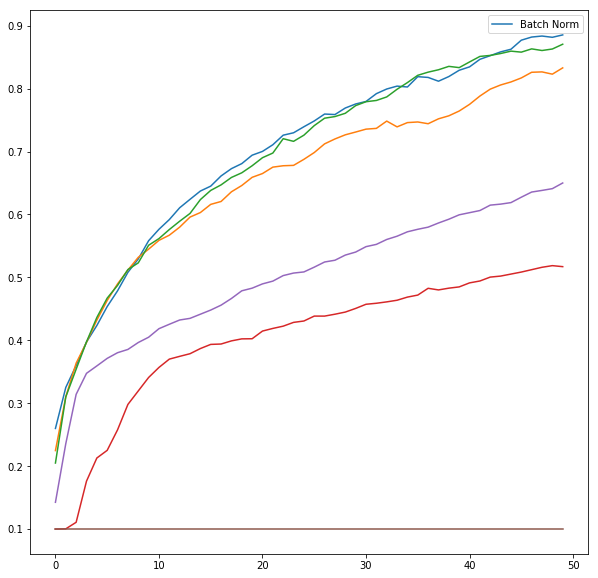

In [61]:
# compare the train accuracy
batch_norm    = np.load('1 batch_norm/train.npy')
layer_norm    = np.load('2 layer_norm/train.npy')
instance_norm = np.load('3 Instance Norm/train.npy')
ranged_norm   = np.load('4 ranged normalization/train.npy')
box_cox       = np.load('5 box cox/train.npy')
svd           = np.load('6 SVD/train.npy')

plt.figure(figsize=(10,10))
plt.plot(batch_norm,label='Batch Norm')
plt.plot(layer_norm,label='Batch Norm')
plt.plot(instance_norm,label='Instance Norm')
plt.plot(ranged_norm,label='Ranged Normalization')
plt.plot(box_cox,label='Box Cox')
plt.plot(svd,label='SVD')
plt.legend()
plt.show()


In [55]:
! start .